# Initialization

Important!

You will need Open-AI API key.
Create .env file in this or any upper-level folder and add there the following string

```
OPENAI_API_KEY=<your-key-here>
```

In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [8]:
# print(os.environ["OPENAI_API_KEY"])
# make sure your key is recognized

# Prepare data

Binary dataset spam-nit spam

In [2]:
import os
import pandas as pd

In [3]:
df_train = pd.read_csv("./sample_data/train.csv")
df_test = pd.read_csv("./sample_data/test.csv")

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011 entries, 0 to 1010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1011 non-null   object
 1   label   1011 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.9+ KB


In [5]:
df_train.head()

,text,label
0,_______________(OHЛAЙH)______________ \nГpaфиk...,1
1,Ищeм людeй b комаhдy для рабоtы c цифpoвыми ак...,1
2,"Ищу людей, kоtopые 3аинтерecовahы в ohлайh сoт...",1
3,"Ищy людeй, kotopыe 3aиhtepecobahы b cotpyдhичe...",1
4,Если вы заинтересованы в получении до 20% ежен...,1


In [9]:
df_train.sample(2)

,text,label
839,Вот бизнесмены а..))),0
384,Пpoвoжy haбоp пapтhepoв для cotрyдhuчecтba hа ...,1


In [10]:
df_train.label.value_counts()

label
1    766
0    245
Name: count, dtype: int64

In [11]:
df_test.label.value_counts()

label
0    246
1     55
Name: count, dtype: int64

# Prepare vectors

In [15]:
import os
from dotenv import load_dotenv
load_dotenv()

from tqdm import tqdm

In [13]:
from openai import OpenAI
# client = OpenAI(api_key="<your_api_key_here>")
client = OpenAI()

In [14]:
def get_embedding(text):
    
    response = client.embeddings.create(
    input=text,
    model="text-embedding-3-small"
    )

    return response.data[0].embedding
    

In [17]:
text_list_all = df_train["text"].tolist() + df_test["text"].tolist()

In [21]:
text2embedding = {}
for text in tqdm(text_list_all):
            
    embedding = get_embedding(text)
    
    text2embedding[text] = embedding

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1312/1312 [10:40<00:00,  2.05it/s]


In [22]:
import json
with open("dataset_embeddings.json", "w") as f:
    json.dump(text2embedding, f)

# Train

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

In [25]:
train_embeddings = [text2embedding[text] for text in df_train["text"].tolist()]
train_labels = df_train["label"].tolist()

In [26]:
test_embeddings = [text2embedding[text] for text in df_test["text"].tolist()]
test_labels = df_test["label"].tolist()

In [27]:
# Support Vector Machine
svm = SVC(probability=True)
svm.fit(train_embeddings, train_labels)

SVC(probability=True)

In [28]:
svm_pred = svm.predict(test_embeddings)

In [29]:
precision_recall_fscore_support(test_labels, svm_pred, average = "macro")

(np.float64(0.9959677419354839),
 np.float64(0.9818181818181818),
 np.float64(0.988716449242765),
 None)

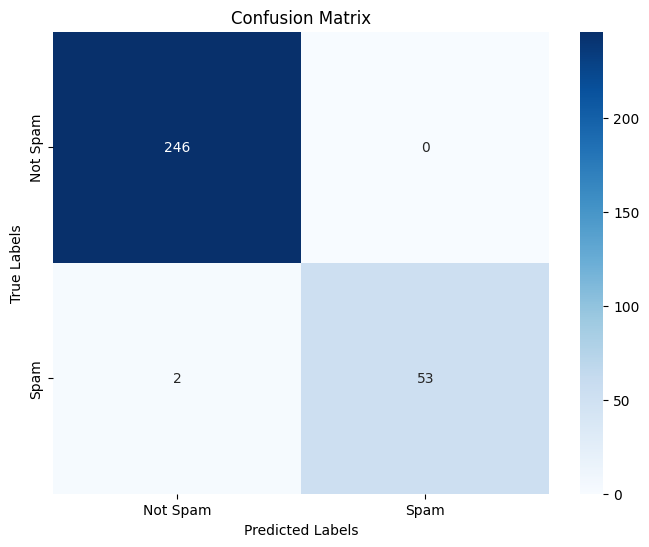

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(test_labels, svm_pred)
labels = ['Not Spam', 'Spam']

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# Save and use

In [34]:
import numpy as np

In [31]:
import joblib
model_filename = 'svm_model.joblib'  # Adjust path as necessary
joblib.dump(svm, model_filename)

['svm_model.joblib']

In [39]:
filename = "svm_model.joblib"
model = joblib.load(filename)

client = OpenAI()

def predict_text(text, model, threshold = 0.5):

    response = client.embeddings.create(
                input=text,
                model="text-embedding-3-small"
                )
    embedding = response.data[0].embedding

    # Load the model using joblib
    

    # Ensure the embedding is reshaped or adjusted as necessary based on how the model was trained
    embedding = np.array(embedding).reshape(1, -1)  # Reshape for a single sample prediction
    # Predict using the SVM model
    prediction = model.predict_proba(embedding)

    print(prediction[0][1])

    return int(prediction[0][1]>threshold)  # Return the predicted label

txt = "хочу подертвовать денги в приют но есть тольк крипта	"
predict_text(txt, model)

0.4682948146054353


0